## Web References

### System

- [How to copy a file without using scp inside an ssh session?](https://superuser.com/questions/291423/how-to-copy-a-file-without-using-scp-inside-an-ssh-session)

### PySpark

- [Complete Machine Learning Project with PySpark MLlib Tutorial](https://www.youtube.com/watch?v=1a7bB1ZcZ3k)
- [The ONLY PySpark Tutorial You Will Ever Need.](https://www.youtube.com/watch?v=cZS5xYYIPzk)
- [PySpark When Otherwise | SQL Case When Usage](https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/)
- [Spark rlike() Working with Regex Matching Examples](https://sparkbyexamples.com/spark/spark-rlike-regex-matching-examples/)
- [spark dataframe drop duplicates and keep first](https://stackoverflow.com/questions/38687212/spark-dataframe-drop-duplicates-and-keep-first)

### Anomaly Detection

- [How to Build an Anomaly Detection Engine with Spark, Akka and Cassandra](https://learning.oreilly.com/videos/how-to-build/9781491955253/9781491955253-video244545/)
- [Real Time Detection of Anomalies in the Database Infrastructure using Apache Spark](https://www.youtube.com/watch?v=1IsMMmug5q0)

### Other

- [What is CRISP DM?](https://www.datascience-pm.com/crisp-dm-2/)

### Internet Traffic

- [Data mining approach for predicting the daily Internet data traffic of a smart university](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0176-5)

## Import Libraries

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, asc, desc, col

import matplotlib.pyplot as plt
import seaborn as sns

## HDFS Preparation

In [2]:
%%bash
#!/bin/bash

# delete the 
if hadoop fs -test -d router; then
    # delete the output directory
    hadoop fs -rm -r router/output

    # create a new output directory
    hadoop fs -mkdir router/output
else
    # create the router directory and upload the input files
    hadoop fs -mkdir router
    hadoop fs -mkdir router/sample
    hadoop fs -put data/bandwidth.csv router/sample/

    hadoop fs -put data/raw router/raw

    # create the output directory
    hadoop fs -mkdir router/output
fi

hadoop fs -ls router/raw

Found 207 items
-rw-r--r--   3 jfoul001 users     150806 2022-03-06 08:41 router/raw/20220304T2210.csv.gz
-rw-r--r--   3 jfoul001 users     149945 2022-03-06 08:41 router/raw/20220304T2220.csv.gz
-rw-r--r--   3 jfoul001 users     149142 2022-03-06 08:41 router/raw/20220304T2230.csv.gz
-rw-r--r--   3 jfoul001 users     151781 2022-03-06 08:41 router/raw/20220304T2240.csv.gz
-rw-r--r--   3 jfoul001 users     150343 2022-03-06 08:41 router/raw/20220304T2250.csv.gz
-rw-r--r--   3 jfoul001 users     149798 2022-03-06 08:41 router/raw/20220304T2300.csv.gz
-rw-r--r--   3 jfoul001 users     148781 2022-03-06 08:41 router/raw/20220304T2310.csv.gz
-rw-r--r--   3 jfoul001 users     148639 2022-03-06 08:41 router/raw/20220304T2320.csv.gz
-rw-r--r--   3 jfoul001 users     149012 2022-03-06 08:41 router/raw/20220304T2330.csv.gz
-rw-r--r--   3 jfoul001 users     150019 2022-03-06 08:41 router/raw/20220304T2340.csv.gz
-rw-r--r--   3 jfoul001 users     150122 2022-03-06 08:41 router/raw/20220304T2350.c

## Initialize the Spark Session

In [3]:
spark = SparkSession.builder.appName('cw02').getOrCreate()
spark

Setting default log level to "ERROR".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## I. Data Understanding

Identify, collect, and analyze the data sets that will help accomplish the project goals

### A. Collect Initial Data

In [4]:
#input_path = 'router/sample/bandwidth.csv'
input_path = 'router/raw/'

# read the full batch to process
df_batch = spark.read.csv(input_path, header=False, inferSchema=True) \
    .toDF('Direction','Interval Length','Intervals Saved','IP','Interval Start','Interval End','Bytes Used')

In [5]:
# drop the intervals saved column
df_batch = df_batch.drop('Intervals Saved')
df_batch.count()

4284780

Remove records related to a specific upload or download class. This is done because this information is not relevant to the project, and have an additional column that will complicate data processing.

In [6]:
df_batch_preproc = df_batch.where(df_batch['Interval Length'].contains('class_') == False)
df_batch_preproc.count()

3521471

### B. Describe data

Examine the data and document its surface properties like data format, number of records, or field identities.

#### 1. Data Format

In [7]:
df_batch_preproc.printSchema()

root
 |-- Direction: string (nullable = true)
 |-- Interval Length: string (nullable = true)
 |-- IP: string (nullable = true)
 |-- Interval Start: string (nullable = true)
 |-- Interval End: integer (nullable = true)
 |-- Bytes Used: long (nullable = true)



In [8]:
df_batch_preproc.count()

3521471

#### 2. Remove Duplicates

Many duplicate records are present in the raw data since the data snapshots overlaps.

In [9]:
# drop duplicates
df_unique = df_batch_preproc.drop_duplicates()
df_unique.count()

660865

There are duplicates where only the `Bytes Used` field is different due to when the data snapshot was taken.

In [10]:
df_unique = df_unique.groupBy(['Direction','Interval Length','IP','Interval Start','Interval End']) \
    .max('Bytes Used') \
    .withColumnRenamed('max(Bytes Used)', 'Bytes Used')

df_unique.count()

634365

In [11]:
df_unique.show(5)

+---------+---------------+-------------+--------------+------------+----------+
|Direction|Interval Length|           IP|Interval Start|Interval End|Bytes Used|
+---------+---------------+-------------+--------------+------------+----------+
| download|          month|192.168.3.218|    1622498400|  1625090400| 326916468|
|   upload|              2|192.168.1.108|    1646481222|  1646481224|         0|
|   upload|              2| 192.168.1.11|    1646477900|  1646477902|        52|
| download|              2|     COMBINED|    1646447314|  1646447316|    918723|
| download|         minute|192.168.3.134|    1646489220|  1646489280|         0|
+---------+---------------+-------------+--------------+------------+----------+
only showing top 5 rows



### C. Explore data

Dig deeper into the data. Query it, visualize it, and identify relationships among the data.

#### 1. Unique Categories

In [12]:
# if an IP address is stored in the IP column recode it as simply 'IP'
df_interval_type = df_unique.withColumn('interval_type', 
    when(df_unique['IP']
    .rlike('^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'), 'IP')
    .otherwise(df_unique['IP'])
)

df_interval_type.groupBy(['interval_type']).count().show()

+-------------+------+
|interval_type| count|
+-------------+------+
|           IP|498659|
|     COMBINED|135706|
+-------------+------+



In [13]:
# record count per catergory
df_interval_type.groupBy(['Interval Length', 'interval_type']) \
    .count() \
    .orderBy(['Interval Length', 'interval_type',], ascending=True) \
    .show(df_interval_type.count())

+---------------+-------------+------+
|Interval Length|interval_type| count|
+---------------+-------------+------+
|            180|     COMBINED|  3186|
|              2|     COMBINED|124958|
|              2|           IP|388270|
|           7200|     COMBINED|   788|
|            900|     COMBINED|   602|
|            900|           IP| 13773|
|            day|     COMBINED|   736|
|            day|           IP|  3638|
|           hour|     COMBINED|   162|
|           hour|           IP|  4522|
|         minute|     COMBINED|  5252|
|         minute|           IP| 85571|
|          month|     COMBINED|    22|
|          month|           IP|  2885|
+---------------+-------------+------+



#### 2. How many intervals are available for the various categories?

This number should be less as for every interval there could be multiple IP addresses (where `interval_type == 'IP'`).

In [14]:
df_interval_type.drop_duplicates(['Direction', 'Interval Length', 'interval_type', 'Interval Start', 'Interval End']) \
    .groupBy(['Interval Length', 'interval_type']) \
    .count() \
    .orderBy(['Interval Length', 'interval_type',], ascending=True) \
    .show(df_interval_type.count())

+---------------+-------------+------+
|Interval Length|interval_type| count|
+---------------+-------------+------+
|            180|     COMBINED|  3186|
|              2|     COMBINED|124958|
|              2|           IP|125043|
|           7200|     COMBINED|   788|
|            900|     COMBINED|   602|
|            900|           IP|   602|
|            day|     COMBINED|   736|
|            day|           IP|    68|
|           hour|     COMBINED|   162|
|           hour|           IP|   162|
|         minute|     COMBINED|  5252|
|         minute|           IP|  4564|
|          month|     COMBINED|    22|
|          month|           IP|    28|
+---------------+-------------+------+



#### 3. Minute Plot

Group the minute data by interval and show a line plot of the first twho hours for a visual overview of the data.

In [15]:
# get the summarized data
df_interval_bandwidth = df_interval_type \
    .where((df_interval_type['Interval Length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP')) \
    .groupBy(['Interval Start']) \
    .sum('Bytes Used') \
    .orderBy(['Interval Start'], ascending=True) \
    .withColumnRenamed('sum(Bytes Used)', 'Bytes Used') \
    .limit(2 * 60) \
    .toPandas()

df_interval_bandwidth.describe()

,Bytes Used
count,1.200000e+02
mean,2.216871e+07
std,3.043667e+07
min,4.337154e+06
25%,7.530486e+06
50%,9.770354e+06
75%,1.722035e+07
max,1.445253e+08


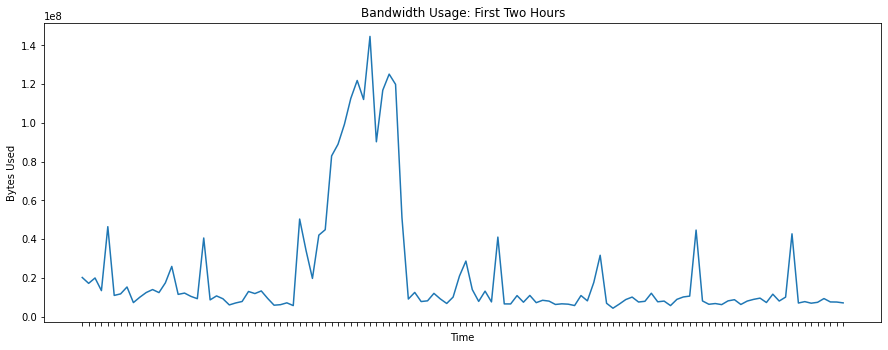

In [16]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_bandwidth,
    x='Interval Start',
    y='Bytes Used',
    ax=ax
).set(
    title='Bandwidth Usage: First Two Hours',
    xlabel='Time',
    xticklabels=[])

plt.show()

#### 4. Number of IP addresses in the last two hours

Notes:

- To count the number of local IP addresses use the `startswith` filter of `192.`
- The dataset contains incomplete intervals where `Interval End == 0` to indicate that the interval was not yet complete when the snapshot was taken.

In [17]:
# the filter on IP is to select only local IP addresses
df_interval_clients = spark.createDataFrame(df_interval_type \
    .where((df_interval_type['Interval Length'] == 'minute') & 
           (df_interval_type['interval_type'] == 'IP') &
           (df_interval_type['IP'].startswith('192.')) &
           (df_interval_type['Interval End'] > 0)) \
    .drop_duplicates(['IP', 'Interval Start', 'Interval End']) \
    .groupBy(['Interval Start']) \
    .count() \
    .orderBy(['Interval Start'], ascending=True) \
    .tail(2 * 60)) \
    .toPandas()

df_interval_clients.describe()

,count
count,120.000000
mean,16.608333
std,1.415970
min,15.000000
25%,15.000000
50%,17.000000
75%,18.000000
max,19.000000


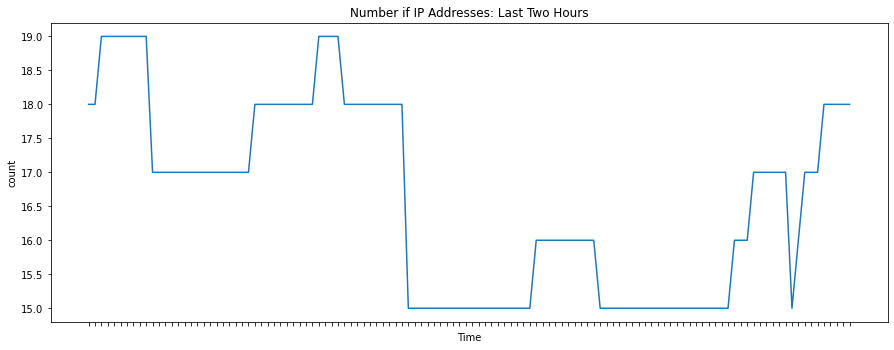

In [18]:
# plot the data
fig_dims = (15, 5.5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=df_interval_clients,
    x='Interval Start',
    y='count',
    ax=ax
).set(
    title='Number if IP Addresses: Last Two Hours',
    xlabel='Time',
    xticklabels=[])

plt.show()